In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quad # integration
from scipy.interpolate import CubicSpline # cubic spline interpolation
from cosmology import H_t, gtilda
from scipy.integrate import solve_ivp
from scipy.integrate import odeint


import fBE_solver as fBE

Testing on a scalar singlet model with $m_S \sim m_h/2$

In [2]:
# Mass of the Higgs boson
mh = 125.1  # GeV
# Mass of the scalar singlet
mS = 62.7 # GeV
# The mass of b-quark (to scatter on)
mf = 4.18  # GeV
# Number of fermions
Nf = 3 # color factor
# we assume that all the fermions have the muon mass


# Number of massless particle degrees of freedom
g_x = 1.0

# Coupling of the scalar singlet to Higgs
lambda_S = 0.1

# Amplitude squared
#M2 = lambda s,t: 0.5*(lambda_S*mf)**2*(4*mf**2 - t)/(t-mh**2)**2
def M2(self,s,t):
    return 2*Nf*(lambda_S*mf)**2*(4*mf**2 - t)/(t-mh**2)**2 # CHECK IF 2 IN FRONT IS COMING FROM PARTICLES AND ANTIPARTICLES
# from Eq. 42 in 1706.07433


In [3]:
FPModel = fBE.Model(mS,g_x,'b') # inititalizing the framework for the solver

FPElastic = fBE.FokkerPlanck(mS,mf,g_x,M2) # instance of the elastic scattering process (in FP approximation)

Defining the grid of x and q values and assigning it to the model

In [4]:
N_x = 100 # number of x points
N_q = 5 # number of q points
xstart = 1.0  # starting x value
xfin = 20.0 # final x value

qin = 0.000001 # starting q value
qend = 20. # final q value

# Creating vectors of linearly distributed values of x and q
x_lin = np.linspace(xstart,xfin,N_x)
q_lin = np.linspace(qin,qend,N_q)

# Assigning the grid (of x and q) to the model
FPModel.changeGrid(x_lin,q_lin)

Now let's add the elastic scattering collision term. So far, this is the only process that we are considering and we want to see how it impacts the shape of the distribution

In [5]:
#FPModel.addCollisionTerm(FPElastic.collisionTerm)

We will actually construct the collision term manually this time, because using the general 2D integration leads to a very long computation time. Perhaps, we can fix that later

In [6]:
# Calculate gamma(x) as in 2103.01944 for each value of x, then construct an interpolator and plug it into the collision term function
k_cm = lambda w: (w**2 - mf**2)/(1.0 + 2*w/mS + (mf/mS)**2)
wmin = mf
wmax = 20.0*wmin # 20.0 is arbitrarily large value, can be smth else (in theory should be infinity)
gamma_integrand = lambda w, x: np.exp(w*x/mS)*( (2*k_cm(w)**2 - 2*mf**2 + mh**2)/(1 + mh**2/(4*k_cm(w)**2)) - (mh**2 - 2*mf**2)*np.log(1.0 + 4*k_cm(w)**2/mh**2) )/(np.exp(w*x/mS)+1.0)**2

gamma_full = np.zeros(np.size(x_lin))

for i,x in enumerate(x_lin):
    gamma_integral, error = quad(lambda w: gamma_integrand(w,x),wmin,wmax)
    gamma_full[i] = 0.5*(Nf*(lambda_S*mf)**2*x/mS)*gamma_integral/(48*np.pi**3*g_x*mS**3)

logGammaSpline = CubicSpline(x_lin,np.log10(gamma_full))
print(gamma_full)

logGamma = lambda x: logGammaSpline(x)          

[3.44031466e-04 3.69208255e-04 3.81351404e-04 3.82506597e-04
 3.74964949e-04 3.60966840e-04 3.42518281e-04 3.21302549e-04
 2.98659860e-04 2.75608782e-04 2.52888796e-04 2.31010062e-04
 2.10302043e-04 1.90956743e-04 1.73064930e-04 1.56645222e-04
 1.41666713e-04 1.28066118e-04 1.15760443e-04 1.04656160e-04
 9.46556636e-05 8.56616977e-05 7.75802731e-05 7.03224831e-05
 6.38055331e-05 5.79532186e-05 5.26960236e-05 4.79709696e-05
 4.37213042e-05 3.98960978e-05 3.64497922e-05 3.33417335e-05
 3.05357103e-05 2.79995109e-05 2.57045071e-05 2.36252691e-05
 2.17392142e-05 2.00262872e-05 1.84686744e-05 1.70505458e-05
 1.57578269e-05 1.45779954e-05 1.34999010e-05 1.25136061e-05
 1.16102455e-05 1.07819026e-05 1.00214999e-05 9.32270332e-06
 8.67983719e-06 8.08781005e-06 7.54204890e-06 7.03844148e-06
 6.57328537e-06 6.14324302e-06 5.74530224e-06 5.37674112e-06
 5.03509715e-06 4.71813989e-06 4.42384670e-06 4.15038128e-06
 3.89607463e-06 3.65940812e-06 3.43899842e-06 3.23358410e-06
 3.04201368e-06 2.863234

here is with my version of that. First: k_cm=k_cm**2 from Eq.7 (1706.07433), which was a typo. I also add non-derivative term of integration by part. The resulting gamma is 5 orders of magnitude larger.

In [7]:
# Calculate gamma(x) as in 2103.01944 for each value of x, then construct an interpolator and plug it into the collision term function
k_cm = lambda w: (w**2 - mf**2)/(1.0 + 2*w/mS + (mf/mS)**2)#checked, but this is k_cm^2!, so it applies to later results
wmin = mf
wmax = 20.0*wmin # 20.0 is arbitrarily large value, can be smth else (in theory should be infinity)
dg=lambda w, x: -(w/mS)*np.exp(w*x/mS)/(np.exp(w*x/mS)+1)**2
g=lambda w, x: 1//(np.exp(w*x/mS)+1)
k4M2=lambda w,x: ( (2*k_cm(w) - 2*mf**2 + mh**2)/(1 + mh**2/(4*k_cm(w))) - (mh**2 - 2*mf**2)*np.log(1.0 + 4*k_cm(w)/mh**2) )

# gamma_integrand = lambda w, x: ( (2*k_cm(w) - 2*mf**2 + mh**2)/(1 + mh**2/(4*k_cm(w))) - (mh**2 - 2*mf**2)*np.log(1.0 + 4*k_cm(w)/mh**2) )/(np.exp(w*x/mS)+1.0)

gamma_full = np.zeros(np.size(x_lin))

for i,x in enumerate(x_lin):

    gamma_integral, error = quad(lambda w: dg(w,x)*k4M2(w,x),wmin,wmax)
    gamma_integral=(g(wmax,x)*k4M2(wmax,x)-0)-gamma_integral #I've checked analytically that g(wmin)->0
    gamma_full[i] = 0.5*(Nf*(lambda_S*mf)**2*x/mS)*gamma_integral/(48*np.pi**3*g_x*mS**3)

logGammaSpline = CubicSpline(x_lin,np.log10(gamma_full))
print(gamma_full)
logGamma = lambda x: logGammaSpline(x)   

[7.20428211e-09 7.63353413e-09 7.77068365e-09 7.66890480e-09
 7.38559401e-09 6.97518483e-09 6.48495252e-09 5.95325918e-09
 5.40947107e-09 4.87484152e-09 4.36382792e-09 3.88549891e-09
 3.44483845e-09 3.04385921e-09 2.68250176e-09 2.35933151e-09
 2.07206060e-09 1.81792725e-09 1.59396309e-09 1.39717528e-09
 1.22466548e-09 1.07370296e-09 9.41765246e-10 8.26556184e-10
 7.26009002e-10 6.38279520e-10 5.61733433e-10 4.94930279e-10
 4.36605935e-10 3.85654851e-10 3.41112797e-10 3.02140603e-10
 2.68009151e-10 2.38085735e-10 2.11821804e-10 1.88742061e-10
 1.68434819e-10 1.50543535e-10 1.34759397e-10 1.20814872e-10
 1.08478095e-10 9.75480090e-11 8.78501547e-11 7.92330416e-11
 7.15650112e-11 6.47315353e-11 5.86328872e-11 5.31821370e-11
 4.83034248e-11 4.39304741e-11 4.00053115e-11 3.64771634e-11
 3.33015061e-11 3.04392454e-11 2.78560104e-11 2.55215424e-11
 2.34091675e-11 2.14953406e-11 1.97592507e-11 1.81824784e-11
 1.67486996e-11 1.54434278e-11 1.42537904e-11 1.31683337e-11
 1.21768534e-11 1.127024

In [8]:

print(gamma_integrand(0,10)-gamma_integrand(100,10),gamma_integrand(0,13)-gamma_integrand(100,13))
print(logGammaSpline(13))

-1.035877821013185 0.28218538154212724
-10.864225595520143


Let's plot the gamma function and compare the results of the interpolation

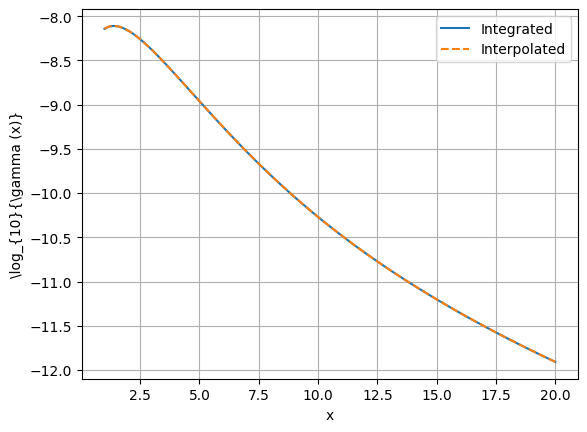

In [9]:
plt.figure()
plt.plot(x_lin,np.log10(gamma_full))
x_test = np.linspace(xstart,xfin,N_x*10)
plt.plot(x_test,logGamma(x_test),'--')
plt.xlabel('x')
plt.ylabel('\log_{10}{\gamma (x)}')
plt.legend(["Integrated", "Interpolated"],loc="upper right")
plt.grid()
plt.show()

Constructing the collision term by hand
Note, that here we use the non-relativistic Fokker-Planck collision term, given by Eq. 5 in 1706.07433

In [10]:
def FPCollTerm(x,q,f,dfdq,d2fdq2): # general shape for the colision term function\
    #eq = np.sqrt(q**2 + x**2)
    eq = x + 0.5*q**2/x
    #print(x*d2fdq2 + (q - 2*x/q)*dfdq + (1.0 + 2*x/q**2)*f)
    return g_x*x*( 10**(logGamma(x)) )*(x*d2fdq2 + (q - 2*x/q)*dfdq + (1.0 + 2*x/q**2)*f)/(eq*q**2) # small momentum transfer formula (eq. 5 in 1706.07433)
    #return q**2*(x*d2fdq2 + (q - 2*x/q)*dfdq + (1.0 + 2*x/q**2)*f)
    #return np.zeros(q.size) # that's what is expected analytically for equilibrium distribution
    #result = g_x*x*( 10**(logGamma(x)) )*(x*d2fdq2 + (q - 2*x/q)*dfdq + (1.0 + 2*x/q**2)*f)/(eq*q**2) 
    #np.insert(result,0,0.0
    #return result

#FPModel.addCollisionTerm(FPCollTerm)

We start with the initial condition distribution function being just the non-relativistic equilibrium function (Maxwell-Boltzmann). The expression below is obtained with the formula 

\begin{equation}
E \approx m + p^2/2m
\end{equation}

In [11]:
f0 = q_lin**2*np.exp(-x_lin[0] - 0.5*q_lin**2/x_lin[0]) # initial condition

Below we test the numerical derivations of the distribution function using 'gradient' method of Numpy and printing the first 100 values of the collision term

In [12]:
dq = q_lin[1]-q_lin[0]
#f0 = q_lin**2*np.exp(-x_lin[0] - 0.5*q_lin**2/x_lin[0])
f0 = q_lin**2*np.exp(-x_lin[0] - 0.5*q_lin**2/x_lin[0])
feq = q_lin**2*np.exp(-x_lin[0] - 0.5*q_lin**2/x_lin[0])
df0dq = np.gradient(f0,dq)
#df0dq[0] = 0.5*( (f0[1]-f0[0])/(q_lin[1]-q_lin[0]) + f0[0]/q_lin[0] )
df0dq[0] = (f0[0]/q_lin[0])*(2 - q_lin[0]**2/x_lin[0]) # try to regularize the first value of the derivative
d2f0dq2 = np.gradient(df0dq,dq)
#d2f0dq2[0] = 0.5*( (df0dq[1]-df0dq[0])/(q_lin[1]-q_lin[0]) + df0dq[0]/q_lin[0] )
d2f0dq2[0] = (f0[0]/q_lin[0]**2)*(2 - 5*q_lin[0]**2/x_lin[0] + q_lin[0]**4/x_lin[0]**2) # trying to regularize the first value of the second derivative

# the regularizations introduced above seem to work, but doesn't really help with the numerical solution of the PDE

print(FPCollTerm(x_lin[0],q_lin,f0,df0dq,d2f0dq2)[0:100])
#CI = FPCollTerm(x_lin[0],q_lin,f0,np.gradient(f0,dq),np.gradient(np.gradient(f0,dq),dq))

[-7.99835988e-13  7.81252225e-16 -4.74470891e-17  9.66886175e-20
  1.27158090e-35]


Solving the fBE manually with a function defined below (for easier troubleshooting)

The "regularization" of the first values of $df/dq$ and $d^2f/dq^2$ comes from the actual (analytical) shape of the Maxwell-Boltzmann distribution at low $q$ and is assumed to hold at least in the example that we consider (it is also present in the cell above)

In [13]:
def solve_fBE(x,q,f0,CollTerm,g,m):
        # x and q are vectors
        # CI is the collision integral - should be a function that takes two values (x,q)
        # f0 should be a vector of initial values (of the same length as q)
    
        # Sizes of x and q arrays
        sx = x.size
        sq = q.size
        
        # Size of q cell
        dq = q[-1]-q[-2]
        
    
        def fBE_RHS(x,fq):
            dfq_x = np.zeros(sq)

            feq = q**2*np.exp(-x - 0.5*q**2/x)
          
            dfdq = np.gradient(fq,dq)
            dfdq[0] = (fq[0]/q[0])*(2 - q[0]**2/x) # regularizing the first value of the derivative
            d2fdq2 = np.gradient(dfdq,dq)
            d2fdq2[0] =  (fq[0]/q[0]**2)*(2 - 5*q[0]**2/x + q[0]**4/x**2) # regularizing the first value of the second derivative

            # dfq_x = ( gtilda(m/x)*( q*dfdq - 2*fq ) + q**2*( CollTerm(x,q,fq,dfdq,d2fdq2)/(2*g) )/H_t(m/x) )/x # q is included in the collision term now
            # print(2*g*H_t(m/x),'   ',x)
            dfq_x = ( gtilda(m/x)*( q*dfdq - 2*fq ) + q**2*CollTerm(x,q,fq,dfdq,d2fdq2)/( 2*g*H_t(m/x) ) )/x # q is included in the collision term now
            

            #below does not raise error:
            # dfq_x2 = ( gtilda(m/x)*( q*dfdq - 2*fq ) + q**2*CollTerm(x,q,fq,dfdq,d2fdq2))/x#/( 2*g*H_t(m/x) ) )/x
            #dfq_x = ( gtilda(m/x)*( q*dfdq - 2*fq ) + q**2*( CollTerm(x,q,0,0,0)/(2*g) )/H_t(m/x) )/x # q is included in the collision term now

            # print(dfq_x2[0],dfq_x2[0])
            print(dfq_x)
            return dfq_x
        
        # print(x[0],x[-1],x)
        fBE_sol = solve_ivp(fBE_RHS,[x[0], x[-1]], f0, method='LSODA', rtol=1e-1, atol=0)
        print(fBE_sol.message)
        x_sol = fBE_sol.t
        f = np.transpose(fBE_sol.y)


        return f, x_sol
        # fBE_sol=odeint(fBE_RHS, f0,x,  rtol=1e-1, atol=0)


        # x_sol = fBE_sol.t
        # f = np.transpose(fBE_sol.y)

        # return fBE_sol, x




f, x_sol = solve_fBE(x_lin,q_lin,f0,FPCollTerm,g_x,mS)
print(f)
# print(f.shape)


[-6.46243056e-11  1.57806759e+00 -3.83359403e-01  1.75773270e-03
  4.10959416e-19]
[-6.46243056e-11  1.57806759e+00 -3.83359403e-01  1.75773270e-03
  4.10959416e-19]
[-6.46243056e-11  1.57806759e+00 -3.83359403e-01  1.75773270e-03
  4.10959416e-19]
[-6.46243056e-11  1.57806759e+00 -3.83359403e-01  1.75773270e-03
  4.10959416e-19]
[-6.46243056e-11  1.57806759e+00 -3.83359403e-01  1.75773270e-03
  4.10959416e-19]
[-6.46243056e-11  1.57806759e+00 -3.83359403e-01  1.75773270e-03
  4.10959416e-19]
[-6.46243056e-11  1.57806759e+00 -3.83359403e-01  1.75773270e-03
  4.10959416e-19]
[-6.46243056e-11  1.57806759e+00 -3.83359403e-01  1.75773270e-03
  4.10959416e-19]
[-6.46243056e-11  1.57806759e+00 -3.83359403e-01  1.75773270e-03
  4.10959416e-19]
[-6.46243056e-11  1.57806759e+00 -3.83359403e-01  1.75773270e-03
  4.10959416e-19]
[-6.46243056e-11  1.57806759e+00 -3.83359403e-01  1.75773270e-03
  4.10959416e-19]
[-6.46243056e-11  1.57806759e+00 -3.83359403e-01  1.75773270e-03
  4.10959416e-19]
[-6.

C:\Users\micha\AppData\Local\Temp\ipykernel_20232\2237854022.py:26: RuntimeWarning: overflow encountered in divide
  dfq_x = ( gtilda(m/x)*( q*dfdq - 2*fq ) + q**2*CollTerm(x,q,fq,dfdq,d2fdq2)/( 2*g*H_t(m/x) ) )/x # q is included in the collision term now
c:\Users\micha\anaconda3\lib\site-packages\scipy\integrate\_ivp\lsoda.py:161: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  solver._y, solver.t = integrator.run(


In [14]:
print(1/1e20,1/(1e+20)+1)

1e-20 1.0


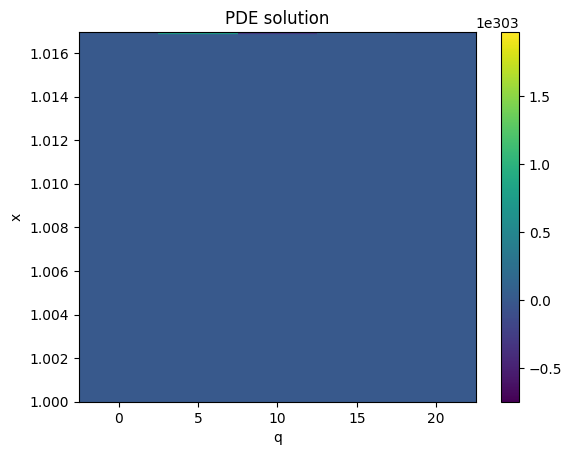

In [15]:
mesh_q,mesh_x = np.meshgrid(q_lin,x_sol)
        
plt.figure()
plt.pcolormesh(mesh_q,mesh_x,f)
plt.colorbar()
plt.gca().set_title('PDE solution')
plt.xlabel('q')
plt.ylabel('x')
plt.show()

In [16]:
print(f[-1,:])


[nan nan nan nan nan]


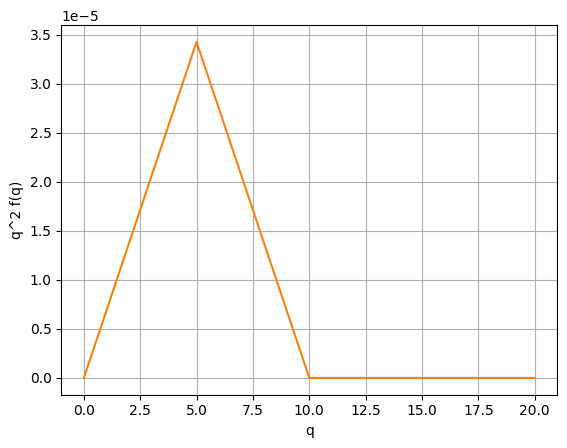

In [17]:
plt.figure()
plt.plot(q_lin,f[-1,:])
plt.plot(q_lin,f[0,:])
plt.xlabel('q')
plt.ylabel('q^2 f(q)')
plt.grid()
plt.show()

In [18]:
print(f[0,:]-f[-1,:])

[nan nan nan nan nan]


Getting the number density from the fBE solution

In [19]:
from cosmology import s_ent

def getDensity(x,q,f,g,m):
    Y_pde = g*np.trapz(f,q, axis=1)*(m/x)**3/2/np.pi**2/s_ent(m/x)

    return Y_pde

C:\Users\micha\AppData\Local\Temp\ipykernel_20232\1311148174.py:4: RuntimeWarning: overflow encountered in multiply
  Y_pde = g*np.trapz(f,q, axis=1)*(m/x)**3/2/np.pi**2/s_ent(m/x)


<function matplotlib.pyplot.show(close=None, block=None)>

c:\Users\micha\anaconda3\lib\site-packages\matplotlib\scale.py:255: RuntimeWarning: overflow encountered in power
  return np.power(self.base, values)


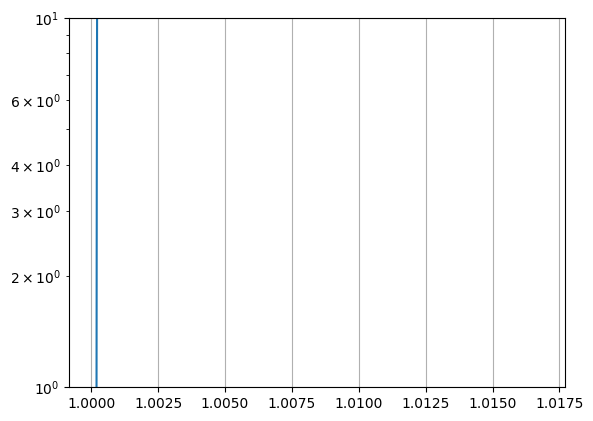

In [20]:
from scipy.special import kn # Bessel function

# Equilibrium comoving density of non-relativistic particles
Y_nr = g_x*mS**3*kn(2,x_sol)/(x_sol*2*np.pi**2)/s_ent(mS/x_sol)
# Solution of the PDE
Y_pde = getDensity(x_sol,q_lin,f,g_x,mS)

plt.figure()
plt.semilogy(x_sol,Y_pde)
#plt.semilogy(x_lin,Y_nr,'--')
plt.grid()
plt.show

In [21]:
#def solve_fBE_x(x,q,f0,CollTerm,g,m): # solving ODEs in q for different x modes 

Below we figure the shape of the initial distribution and its derivatives. For example, to check how the numerical differentiation (gradient) is doing

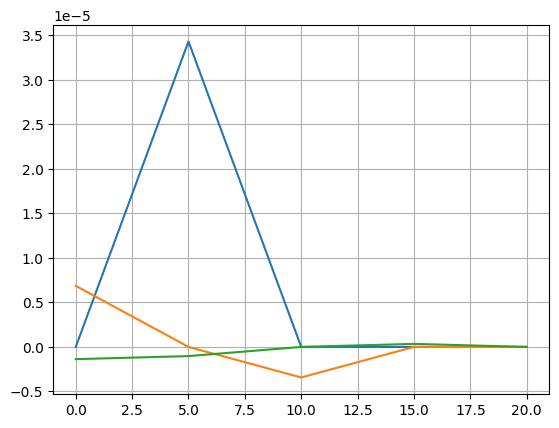

In [22]:
plt.figure
plt.plot(q_lin,f0) # initial condition
plt.plot(q_lin,np.gradient(f0,q_lin[1]-q_lin[0])) # first derivative
plt.plot(q_lin,np.gradient(np.gradient(f0,q_lin[1]-q_lin[0]),q_lin[1]-q_lin[0])) # second derivative
plt.grid()
plt.show()

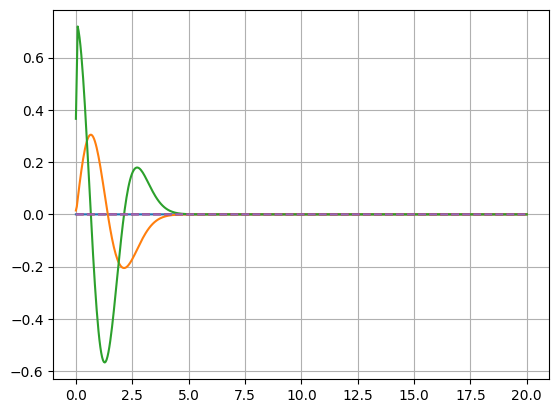

In [23]:
# here we use a broader and more dense grid of q to see if our choice of grid is ok
q_small = np.linspace(q_lin[0]/10,q_lin[-1],N_q*100)
f0_small = q_small**2*np.exp(-x_lin[0] - 0.5*q_small**2/x_lin[0])

plt.figure
plt.plot(q_lin,f0) # initial condition
plt.plot(q_small,np.gradient(f0_small,q_small[1]-q_small[0])) # first derivative
plt.plot(q_small,np.gradient(np.gradient(f0_small,q_small[1]-q_small[0]),q_small[1]-q_small[0])) # second derivative
plt.plot(q_lin,np.gradient(f0,q_lin[1]-q_lin[0]),'--') # first derivative
plt.plot(q_lin,np.gradient(np.gradient(f0,q_lin[1]-q_lin[0]),q_lin[1]-q_lin[0]),'--') # second derivative
plt.grid()
plt.show()
